# fSim gate simulation

here we simulate an fSim gate, focusing on the unitary that is being performed when we play a particular sequence of pulses. We start with the Hamiltonian:

$$
H = \sum_{i=1,2} \left( \omega_i a_i^\dagger a_i + \frac{\eta}{2}a^{\dagger 2}_i a^2_i \right) \\
+ g(t)(a_1^\dagger a_2 + a_2^\dagger a_1)
$$

(open question: how does this get translated to sigma_x sigma_x etc. operators?)

and move to the interaction picture with the Hamiltonian $H_0 = \frac{\omega_1+\omega_2}{2} (a_1^\dagger a_1 + a_2^\dagger a_2$). After doing this transformation we get the Hamiltonian:

$$
H =
\begin{pmatrix}
-\Delta/2 & g & 0 & 0 & 0 \\
g & \Delta/2 & 0 & 0 & 0 \\
0 & 0 & 0 & \sqrt{2}g & \sqrt{2}g \\
0 & 0 & \sqrt{2}g & -\Delta + \eta  & 0\\
0 & 0 & \sqrt{2}g & 0 & \Delta + \eta
\end{pmatrix}
$$

We want to investigate the unitary that stems from this Hamiltonian for different times and initial states.

In [148]:
import qutip as qp
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple
%matplotlib inline

In [96]:
# operator definitions

a = qp.destroy(Nh)
I = qp.qeye(Nh)

a1 = qp.tensor([a, I])
a2 = qp.tensor([I, a])

# transfomration to rotating frame Hamiltonian
H00 = omega_av * (a1 * a1.dag() + a2 * a2.dag())

# static part of interaction Hamiltonian
H01 = (Delta/2)*(a2.dag()*a2-a1.dag()*a1) + (eta/2)*(a1.dag()**2*a1**2 + a2.dag()**2*a2**2) 

# dynamic coupling interaction operators
H10 = a1.dag() * a2 + a2.dag() * a1

# dynamic detuning operators
Hz1 = a2.dag()*a2 - a1.dag()*a1

In [97]:
# general parameters
t_final = 200
Nh = 3

# qubit parameters
omega1 = 5  # GHz
omega2 = 6  # GHz
Delta = omega2 - omega1
omega_av = (omega1 + omega2) / 2
eta = 0.3  # GHz

# pulse parameters
single_pulse_duration = 40  # nsec



In [161]:
# solve schrodinger equation with initial state 00 and pi/2 pulse on qubit 1
tvec = np.arange(0, t_final, 0.2)
psi0 = qp.fock([Nh, Nh], [0, 0])

# time dependent functions


def g(t, args):
    if args['t_start_swap'] < t and t < args['t_start_swap'] + 30:
        return 0.05
    else:
        return 0


def detun(t, args):
    if args['t_start_swap'] < t and t < args['t_start_swap'] + 30:
        return -Delta/2
    else:
        return 0
    

pi_factor1 = 0.5
pi_factor2 = 0.5

ts1 = 10
ts2 = 203


def cosine_pulse(t, t_start, duration):
    return 0.5 * np.pi * np.pi * np.cos(2*np.pi*(t - t_start - duration/2)/(2*duration)) / duration


def q1_drive(t, **args):  # this is the baseband signal
    if ts1 < t and t < ts1 + single_pulse_duration:
        return pi_factor1 * cosine_pulse(t, ts1, single_pulse_duration)
#     if ts2 < t and t < ts2 + single_pulse_duration:
#         return pi_factor1 * cosine_pulse(t, ts2, single_pulse_duration)
    else:
        return 0

    
def q2_drive(t, **args):  # this is the baseband signal
    if ts1 < t and t < ts1 + single_pulse_duration:
        return pi_factor2 * cosine_pulse(t, t_start_single, single_pulse_duration)
#     if ts2 < t and t < ts2 + single_pulse_duration:
#         return pi_factor1 * cosine_pulse(t, ts2, single_pulse_duration)
    else:
        return 0


def a1_dr(t, args):
    return 0.5 * q1_drive(t, **args) * np.exp(-1j *(Delta/2) * t)


def a1d_dr(t, args):
    return 0.5 * q1_drive(t, **args) * np.exp(1j * (Delta/2) * t)


def a2_dr(t, args):
    return 0.5 * q2_drive(t, **args) * np.exp(-1j * (-Delta/2) * t)


def a2d_dr(t, args):
    return 0.5 * q2_drive(t, **args) * np.exp(1j * (-Delta/2) * t)


H = [H01,
     [H10, g],
     [Hz1, detun],
     [a1, a1_dr],
     [a1.dag(), a1d_dr],
     [a2, a2_dr],
     [a2.dag(), a2d_dr],
    ]


args_dict = {'t_start_swap': 70}
sol = qp.sesolve(H, psi0, tvec,
                 args=args_dict,
                 e_ops = [a1.dag()*a1, a2.dag()*a2],
                 options=qp.Options(max_step=1))

## expectation values for a single SWAP time

<n1> last = 0.4691652094625409, <n2> last = 0.5177997633018695


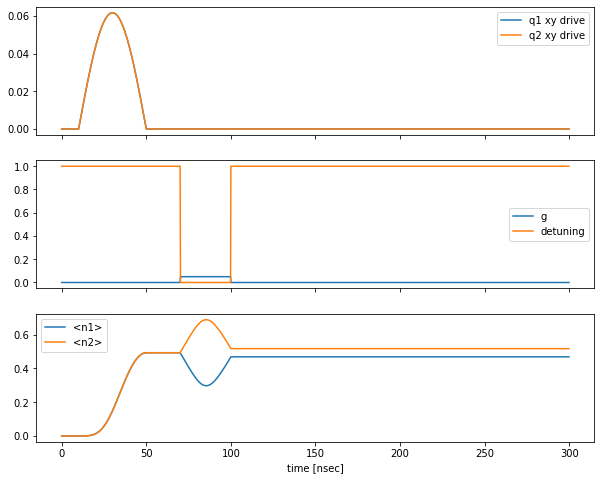

In [162]:
sol.expect[0]
fig, ax = plt.subplots(3, 1, sharex='all', figsize=(10, 8))
axn = ax[0]
axn.plot(sol.times, [q1_drive(t) for t in sol.times], label='q1 xy drive')
axn.plot(sol.times, [q2_drive(t) for t in sol.times], label='q2 xy drive')
axn.legend()
axn = ax[1]
axn.plot(sol.times, [g(t, args_dict) for t in sol.times], label='g')
axn.plot(sol.times, [Delta + 2 * detun(t, args_dict) for t in sol.times], label='detuning')
axn.legend()
axn = ax[2]
axn.plot(sol.times, sol.expect[0], label='<n1>')
axn.plot(sol.times, sol.expect[1], label='<n2>')
ax[-1].set_xlabel('time [nsec]')
plt.legend()
print(f'<n1> last = {sol.expect[0][-1]}, <n2> last = {sol.expect[1][-1]}')

### final expectation values for a sweep on SWAP start time

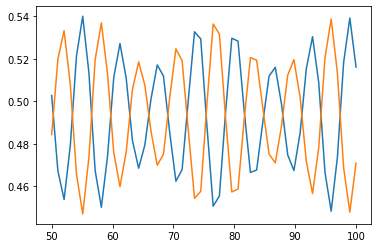

In [163]:
t_start_swap_vec = np.linspace(50, 100, 50)
n1_final = []
n2_final = []
for t_start_swap in t_start_swap_vec:
    args_dict = {'t_start_swap': t_start_swap}
    sol = qp.sesolve(H, psi0, tvec,
                     args=args_dict,
                     e_ops = [a1.dag()*a1, a2.dag()*a2],
                     options=qp.Options(max_step=1))
    n1_final.append(sol.expect[0][-1])
    n2_final.append(sol.expect[1][-1])
    
n1_final = np.array(n1_final)
n2_final = np.array(n2_final)

plt.plot(t_start_swap_vec, n1_final)
plt.plot(t_start_swap_vec, n2_final)